# Conditional neural process

## Loss function

The conditional neural process uses a neural network to model the conditional distribution $y_T | x_{T}, x_{C}, y_{C}$

$$ \mathcal{L} = \mathbb{E}_f \left[\mathbb{E}_N \left[ \log p(y_{1:N} | x_{1:N}, y_{1:K}) \right]\right]$$

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt

from utils import eq_covariance,              \
                  sample_1d_datasets_from_gp

In [159]:
x_min = -4.
x_max = 4.
num_datasets = 64
num_datapoints = 30
scale = 2e0
cov_coeff = 1e0
noise_coeff = 1e-2

x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                  x_max=x_max,
                                  num_datasets=num_datasets,
                                  num_datapoints=num_datapoints,
                                  scale=scale,
                                  cov_coeff=cov_coeff,
                                  noise_coeff=noise_coeff)

x, y = x[..., None], y[..., None]

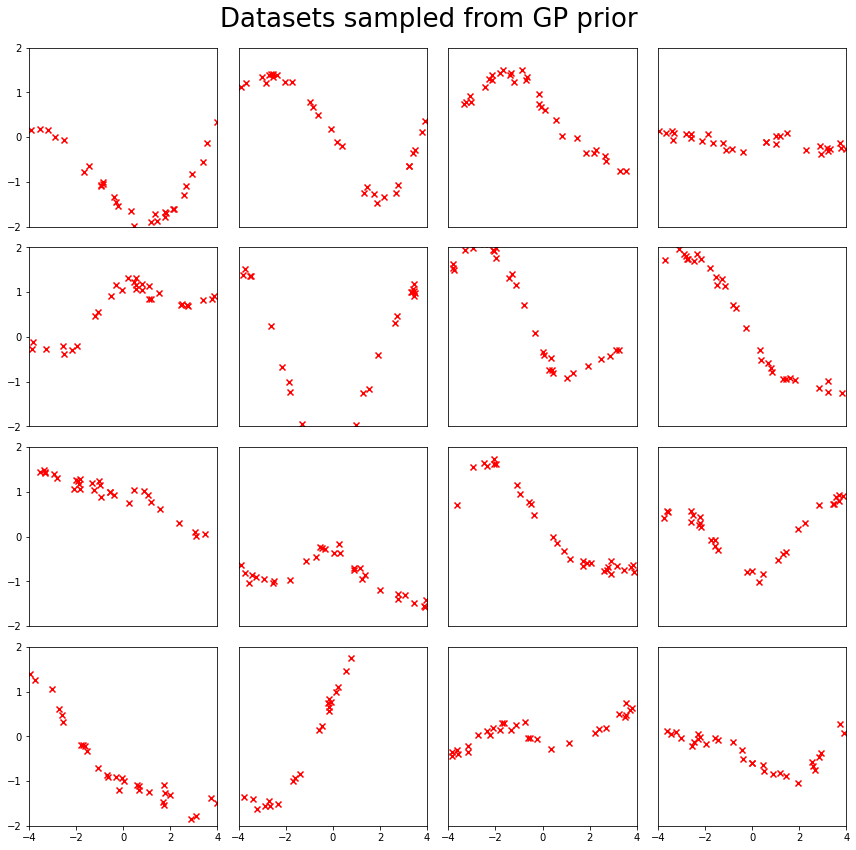

In [160]:
plt.figure(figsize=(12, 12))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.scatter(x[i, :, 0], y[i, :, 0], marker='x', color='red')
    
    plt.xlim([-4, 4])
    plt.ylim([-2, 2])
    
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-2, 2, 5))
    
    if i % 4 != 0:
        plt.yticks([])
        
    if i <= 11 != 0:
        plt.xticks([])

plt.suptitle('Datasets sampled from GP prior', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We define a CNP to be the collection of an `encoder` and a `decoder` object. The `encoder` will map the context points to a single context vector. The `decoder` will map the context vector and each of the target inputs, to distributions over the target outputs.

In [266]:
class CNP(tf.Module):
    
    def __init__(self, encoder, decoder, name='cnp', **kwargs):
        
        
        super().__init__(name=name, **kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def __call__(self, xc, yc, xt):
        
        r = self.encoder(xc, yc)
        yt_dist = self.decoder(xt, r)
        
        return yt_dist
    
    
    def loss(self, x, y, num_samples):
        
        num_batches = x.shape[0]
        batch_size = x.shape[1]
        
        loglik = 0
        
        for i in range(num_samples):
            
            n = tf.cast((batch_size - 1) * tf.random.uniform(()), dtype=tf.int32) + 1
            
            xc = x[:, :n, :]
            yc = y[:, :n, :]
            
            y_dist = self.__call__(xc, yc, x)
            
            loglik = loglik + tf.reduce_sum(y_dist.log_prob(y)) / (x.shape[0] * x.shape[1])
         
        loss = - loglik / num_samples
        
        return loss

In [267]:
class FeedforwardNetwork(tf.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims,
                 nonlinearity,
                 name='feedforward_netork',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        shapes = [input_dim] + hidden_dims + [output_dim]
        shapes = [(s1, s2) for s1, s2 in zip(shapes[:-1], shapes[1:])]
        
        print(shapes)
        
        self.W = []
        self.b = []
        self.num_linear = len(hidden_dims) + 1
        
        with self.name_scope:
            for shape in shapes:
                
                W = tf.Variable(tf.random.normal(shape=shape) / shape[0] ** 0.5)
                b = tf.Variable(tf.random.normal(shape=shape[1:]))
                
                self.W.append(W)
                self.b.append(b)
        
        self.nonlinearity = getattr(tf.nn, nonlinearity)
        
    
    def __call__(self, tensor):
        
        for i, (W, b) in enumerate(zip(self.W, self.b)):
            
            tensor = tf.einsum('...i, ij -> ...j', tensor, W) + b[None, None, :]
            
            if i < self.num_linear - 1:
                tensor = self.nonlinearity(tensor)
        
        return tensor

In [268]:
class NeuralNetworkEncoder(tf.Module):
    
    def __init__(self, feedforward_network, name='neural_network_encoder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network

    
    def __call__(self, xc, yc):
        
        c = tf.concat([xc, yc], axis=-1)
        r = self.feedforward_network(c)
        r = tf.reduce_mean(r, axis=1, keepdims=True)
        
        return r
        
        
class NeuralNetworkDecoder(tf.Module):
    
    def __init__(self, feedforward_network, likelihood, name='neural_network_decoder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network
        self.likelihood = likelihood

    
    def __call__(self, xt, r):
        
        r = tf.tile(r, multiples=(1, xt.shape[1], 1))
        xt_r = tf.concat([xt, r], axis=2)
        
        param_tensor = self.feedforward_network(xt_r)
        yt_dist = self.likelihood(param_tensor)
        
        return yt_dist

In [281]:
class GaussianLikelihood:
    
    def __init__(self):
        self.dist = tfd.Normal
        
    
    def __call__(self, param_tensor):
        
        loc, scale = self.reparametrise(param_tensor)
        dist = self.dist(loc=loc, scale=scale)
        
        return dist
        
        
    def reparametrise(self, tensor):
        
        mean = tensor[..., :1]
        scale = tf.exp(tensor[..., 1:2])
        
        return mean, scale
    
    
    def loglik(self, param_tensor, data):
        return self.__call__().log_prob(data)

In [ ]:
input_dim = 1
output_dim = 1
rep_dim = 128
enc_hidden_dims = [128, 128]
dec_hidden_dims = [128, 128, 128, 128]
nonlinearity = 'relu'

encoder_ffn = FeedforwardNetwork(input_dim=(input_dim + output_dim),
                                 output_dim=rep_dim,
                                 hidden_dims=enc_hidden_dims,
                                 nonlinearity=nonlinearity)

decoder_ffn = FeedforwardNetwork(input_dim=(input_dim + rep_dim),
                                 output_dim=2*output_dim,
                                 hidden_dims=dec_hidden_dims,
                                 nonlinearity=nonlinearity)

decoder_likelihood = GaussianLikelihood()

encoder = NeuralNetworkEncoder(feedforward_network=encoder_ffn)

decoder = NeuralNetworkDecoder(feedforward_network=decoder_ffn,
                               likelihood=decoder_likelihood)

cnp = CNP(encoder=encoder, decoder=decoder)

learning_rate = 1e-3
num_steps = int(1e5)
num_samples = 1

# optimiser = tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)    

x_min = -4.
x_max = 4.
num_datasets = 20
num_datapoints = 10
scale = 1e0
cov_coeff = 1e0
noise_coeff = 1e-4

for i in range(num_steps):

    x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                      x_max=x_max,
                                      num_datasets=num_datasets,
                                      num_datapoints=num_datapoints,
                                      scale=scale,
                                      cov_coeff=cov_coeff,
                                      noise_coeff=noise_coeff)

    x, y = tf.cast(x[..., None], dtype=tf.float32), tf.cast(y[..., None], dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        
        loss = cnp.loss(x=x, y=y, num_samples=num_samples)
    
    gradients = tape.gradient(loss, cnp.trainable_variables)
    optimiser.apply_gradients(zip(gradients, cnp.trainable_variables))
    
    if i % int(1e2) == 0:
        
        plt.figure(figsize=(15, 4))
        
        for i in range(3):
            
            xlin = tf.linspace(-10., 10., 100)[None, :, None]

            pred_dist = cnp(x[i:i+1, :, :], y[i:i+1, :, :], xlin)

            mean = pred_dist.loc
            scale = pred_dist.scale

            x_plot = np.array(xlin)[0, :, 0]
            mean = np.array(mean)[0, :, 0]
            scale = np.array(scale)[0, :, 0]
            
            plt.subplot(1, 3, i+1)
            plt.plot(x_plot, mean)
            plt.scatter(x[i, :, 0], y[i, :, 0])
            plt.fill_between(x_plot, mean - 2 * scale, mean + 2 * scale, color='gray', alpha=0.5)

            plt.ylim([-5, 5])
            
        plt.show()